In [4]:
IRdisplay::display_html("
<style>
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}
body.rise-enabled div.inner_cell>div.input_area {
    font-size: 150%;
}

body.rise-enabled div.output_subarea.output_text.output_result {
    font-size: 150%;
}
body.rise-enabled div.output_subarea.output_text.output_stream.output_stdout {
  font-size: 150%;
}
</style>
")

In [5]:
library(tidyverse)
library(nycflights13)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


## Review problem (from last lecture)
There are five cuts of diamond: Fair, Good, Very Good, Premium and Ideal. Within each type of cut we can compute the average weight. For example, the average weight of an Ideal diamond is 0.703 carats. If we do this for the other four types of cut we get five averages.

What is the average of these five numbers? In other words, what's the average of the average weight within each cut? 

#### Choices (avg. of averages)
1. $[0.5,0.75)$ cts.
2. $[0.75, 0.85)$ cts.
3. $[0.85, 0.9)$ cts.
4. $[0.9, 1.0)$ cts.

Is this number equal to the average weight when computed over the entire `diamonds` data set?

In [2]:
# Your code here

# Lecture 05


<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will able to:**
* [`summarize()` and `count()`](#Wrapping-up-summarize()) data
* Use groups along with [mutate and filter](#Grouped-mutates-and-filters) ([§5.7](http://r4ds.had.co.nz/transform.html#grouped-mutates-and-filters))
* [Visualize distributions](#Visualizing-distributions) ([§7](http://r4ds.had.co.nz/exploratory-data-analysis.html))
</div>

## How `summarize()` works
`group_by(x) %>% summarize(y=f(col))` is equivalent to:


```filter(x == <value>) %>% mutate(y=f(col))```

for every unique `<value>` of `x`, and then combining all the results.

Here's an example: I want to know how many distinct `dest`inations there were for each month of the year in flights. The `n_distinct()` function takes a vector of values, and returns the number of distinct values:

In [19]:
n_distinct(c("Michigan", "Ohio", "STATS 306", "Michigan"))

[1] 3

So, if I filter to January and then run `n_distinct` on all the `dest`s, that given me the answer:

In [29]:
flj <- flights %>% filter(month == 1) %>% 
    mutate(nd = n_distinct(dest)) %>% select(nd) %>% print

# A tibble: 27,004 x 1
      nd
   <int>
 1    94
 2    94
 3    94
 4    94
 5    94
 6    94
 7    94
 8    94
 9    94
10    94
# ... with 26,994 more rows


The summarize command simply automates this:

In [21]:
flights %>% group_by(month) %>% summarize(nd = n_distinct(dest))

   month nd
1   1    94
2   2    92
3   3    95
4   4    93
5   5    90
6   6    93
7   7    94
8   8    93
9   9    92
10 10    91
11 11    90
12 12    96

### Exercise
How many unique air carriers are in `flights`?

1. 8
2. 12
3. 16
4. 20
5. 26

In [23]:
### Your code here

The `n()` function returns the number of rows in each group:

In [24]:
flights %>% group_by(month) %>% summarize(n = n()) %>% print

# A tibble: 12 x 2
   month     n
   <int> <int>
 1     1 27004
 2     2 24951
 3     3 28834
 4     4 28330
 5     5 28796
 6     6 28243
 7     7 29425
 8     8 29327
 9     9 27574
10    10 28889
11    11 27268
12    12 28135


This is like doing
```filter(month == 1) %>% mutate(n = n())```
and then removing all the duplicates.

### Exercise
Let's say an air carrier is *regional* if its average distance traveled per flight is less than 600 miles, *and* it has at least 500 flights. 

Which of these carriers are regional?

1. UA
2. MQ
3. 4E
4. DL
5. YV

In [15]:
# Your code here

## Grouped mutates and filters
Earlier we saw how to use `group_by()` and `summarize()` to calculate summary statistics across different groups. It is also possible to combine groups with `mutate()` and `filter()`. The following finds the most delayed flight for each day of the year:

In [32]:
flights %>% group_by(month, day) %>% filter(rank(desc(dep_delay)) == 1) %>% print

# A tibble: 370 x 19
# Groups:   month, day [365]
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      848           1835       853     1001           1950
 2  2013     1     2     2131           1512       379     2340           1741
 3  2013     1     3     2056           1605       291     2239           1754
 4  2013     1     4     2123           1635       288     2332           1856
 5  2013     1     5     1344            817       327     1635           1127
 6  2013     1     6     1242            920       202     1527           1233
 7  2013     1     7     2021           1415       366     2332           1724
 8  2013     1     8     1307            959       188     1426           1122
 9  2013     1     9      641            900      1301     1242           1530
10  2013     1    10     1121           1635      1126     1239           1810
# 

### Exercise
The following table shows the most (departure) delayed flight each month. (Some entries have been blanked out.) Find the complete table and paste on Slack:

<table class="table" style="margin-left: auto; margin-right: auto;">
 <thead>
  <tr>
   <th style="text-align:right;"> month </th>
   <th style="text-align:right;"> day </th>
   <th style="text-align:left;"> carrier </th>
   <th style="text-align:right;"> flight </th>
   <th style="text-align:right;"> dep_delay </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:right;"> 1 </td>
   <td style="text-align:right;"> 9 </td>
   <td style="text-align:left;"> HA </td>
   <td style="text-align:right;"> 51 </td>
   <td style="text-align:right;"> 1301 </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 2 </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:left;"> &mdash; </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:right;"> 853 </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 3 </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:left;"> &mdash; </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:right;"> 911 </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 4 </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:left;"> &mdash; </td>
   <td style="text-align:right;"> 2391 </td>
   <td style="text-align:right;"> &mdash; </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 5 </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:left;"> &mdash; </td>
   <td style="text-align:right;"> 3744 </td>
   <td style="text-align:right;"> &mdash; </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 6 </td>
   <td style="text-align:right;"> 15 </td>
   <td style="text-align:left;"> MQ </td>
   <td style="text-align:right;"> 3535 </td>
   <td style="text-align:right;"> &mdash; </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 7 </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:left;"> &mdash; </td>
   <td style="text-align:right;"> 3075 </td>
   <td style="text-align:right;"> &mdash; </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 8 </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:left;"> &mdash; </td>
   <td style="text-align:right;"> 4978 </td>
   <td style="text-align:right;"> &mdash; </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 9 </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:left;"> &mdash; </td>
   <td style="text-align:right;"> 177 </td>
   <td style="text-align:right;"> &mdash; </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 10 </td>
   <td style="text-align:right;"> 14 </td>
   <td style="text-align:left;"> DL </td>
   <td style="text-align:right;"> 502 </td>
   <td style="text-align:right;"> &mdash; </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 11 </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:left;"> &mdash; </td>
   <td style="text-align:right;"> 2042 </td>
   <td style="text-align:right;"> &mdash; </td>
  </tr>
  <tr>
   <td style="text-align:right;"> 12 </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:left;"> &mdash; </td>
   <td style="text-align:right;"> &mdash; </td>
   <td style="text-align:right;"> &mdash; </td>
  </tr>
</tbody>
</table>

In [47]:
# Your code here

## Summary of §5
Before we move on to the next part of the book, I want to spend some time summarizing and tying together the main ideas from the past 2.5 lectures. In chapter 5 we learned about four types of operations for altering data tibbles:
* `filter()`: drop rows from a data table based on certain logical conditions.
* `select()`: keep *columns* in a data table by name, range, or logical conditions.
* `arrange()`: sort / reorder the rows of a data table.
* `mutate()`: generate new columns in a data table by applying functions to the existing ones.
* `group_by()` / `summarize()`: group rows together based on one or more variables, and compute summary statistics within each group.

### Frequently encountered questions
Here are a couple of specific issues that arose in OH and on Canvas:

#### `filter()` vs `select()`
Some students were mixing up the use of `filter()` and `select()`.

#### Filter
`filter()` selects rows:
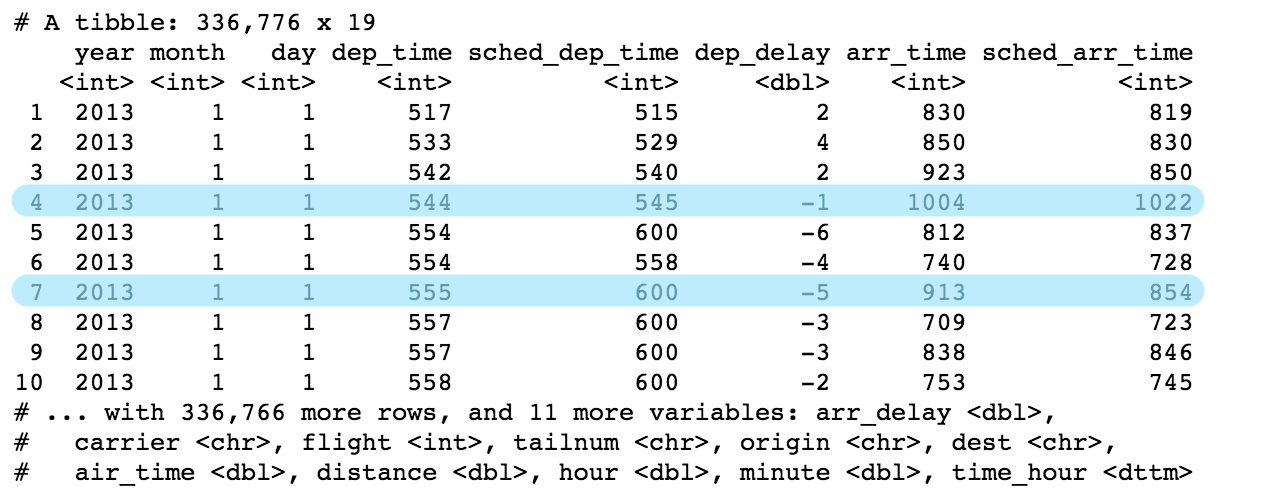

#### Select
`select()` selects columns
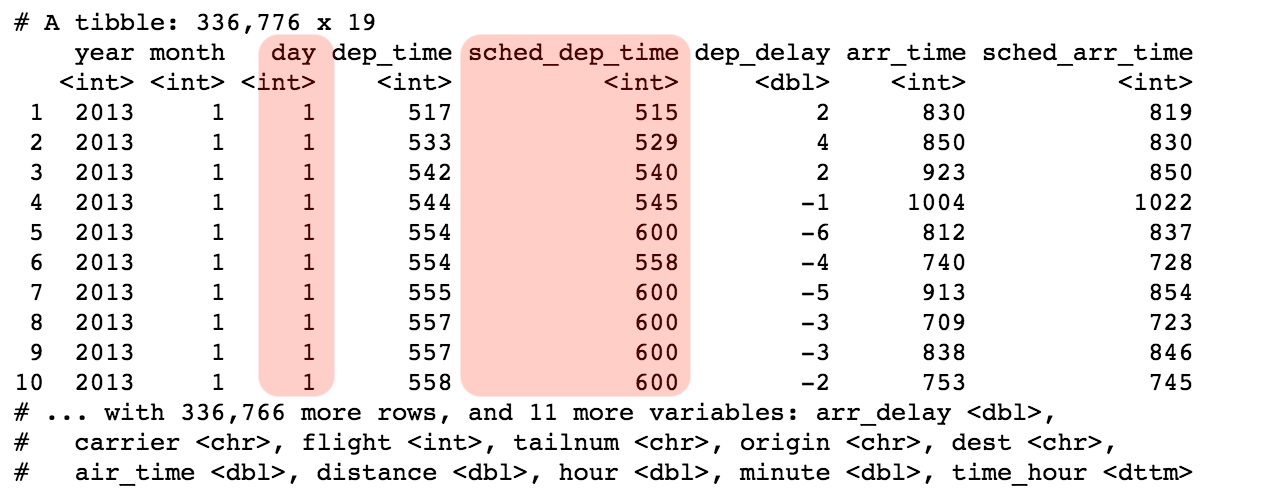

#### When to quote
Columns should not be quoted inside of commands like `filter()`. The following command returns an empty data table. Why? Because the condition evaluates to `FALSE`, which is then recycled up to every row of the table:

In [144]:
#filter(flights, "carrier" == "UA") %>% print  # wrong: compares the string "carrier" to the string "UA"
filter(flights, carrier == "UA") # produces an error: compares the column carrier to the (nonexistent) column UA
# correct: filter(flights, car rier == "UA") 

ERROR: Error in filter_impl(.data, quo): Evaluation error: object 'UA' not found.


#### `=` versus `==`
Remember that `=` and `==` mean different things. The former is used for assignment and to pass keyword parameters to functions. The latter is used to test for equality and returns either `TRUE` or `FALSE`.

In [150]:
#mutate(flights, carrier = "UA")  %>% select(carrier) %>% print
filter(flights, carrier == "UA")  ## error

      year month day dep_time sched_dep_time dep_delay arr_time sched_arr_time
1     2013 1     1   517      515             2         830      819          
2     2013 1     1   533      529             4         850      830          
3     2013 1     1   554      558            -4         740      728          
4     2013 1     1   558      600            -2         924      917          
5     2013 1     1   558      600            -2         923      937          
6     2013 1     1   559      600            -1         854      902          
7     2013 1     1   607      607             0         858      915          
8     2013 1     1   611      600            11         945      931          
9     2013 1     1   623      627            -4         933      932          
10    2013 1     1   628      630            -2        1016      947          
11    2013 1     1   643      646            -3         922      940          
12    2013 1     1   644      636             8     

#### Vector versus column versus data table
There is particular confusion about when it is appropriate to use vectors, columns and data tables. We will be discussing these concepts at greater length in the coming weeks, but here are some essentials that you should know:

**Vectors** in R contain multiple values. You create vectors using the `c()` function. If you do neglect to do this, R will produce an error and/or do the wrong thing. Some examples of this I saw include:
```{r}
a = factor(b, levels=1, 2, 3, 4, 5) ## wrong
a = factor(b, levels=(1, 2, 3, 4, 5)) ## wrong
a = factor(b, levels=c(1, 2, 3, 4, 5)) ## correct
```

Vectors have a particular type, and all the entries of the vector must be of that same type; if they are not R will convert them to be.

In [32]:
c(1,2,'a')  # conversion to string
c(T, T, factor('a'))  # conversion to int

[1] "1" "2" "a"

[1] 1 1 1

You can think of a data table as a list of vectors. Each column has its own vector. To access a vector of values stored in a column in R, we traditionally use the `$` operator:

In [156]:
class(select(flights, tailnum))
typeof(flights$tailnum)

[1] "tbl_df"     "tbl"        "data.frame"

[1] "character"

If working inside one of the `dplyr` functions like `mutate()`, `filter()`, etc., the dataset is specified by the first parameter. So you don't need to use the `$` operator, just specify the column name:
```{r}
filter(flights, flights$arr_delay < 10)  # wrong (although it will work)
filter(flights, arr_delay < 10)  # correct
```

Even though they contain the same information, a column vector is *not the same* as a table containing only that column:

In [34]:
head(flights$arr_time)  # <---- vector     
# is different from...
head(select(flights, arr_time)) # <---- data table

[1]  830  850  923 1004  812  740

  arr_time
1  830    
2  850    
3  923    
4 1004    
5  812    
6  740    

Passing in a data table where R expects a vector will lead to errors. For example, neither of the following are valid:
```{r}
month_factor = factor(flights)
month_factor = factor(select(flights, month))
```
These will take a large amount of time to run because R is creating a huge factor, one with a level for every observation in your data table.

### Worked example
We'll work through an example of how to put all of this together.

In [49]:
p = flights %>% mutate(on_time=arr_delay <= 0) %>% select(month, carrier, on_time) %>% 
    group_by(carrier, month) %>% summarize(on_time_pct=mean(on_time, na.rm=T), n=n()) %>% 
    ggplot(aes(x=factor(month), y=on_time_pct, group=carrier, color=carrier)) + 
    geom_line()

#### Plot the on-time arrival percentage by month for each airline

I want to make the following plot: one line per carrier. Twelve months of data. On the $y$-axis, the percentage of flights that arrived on time.

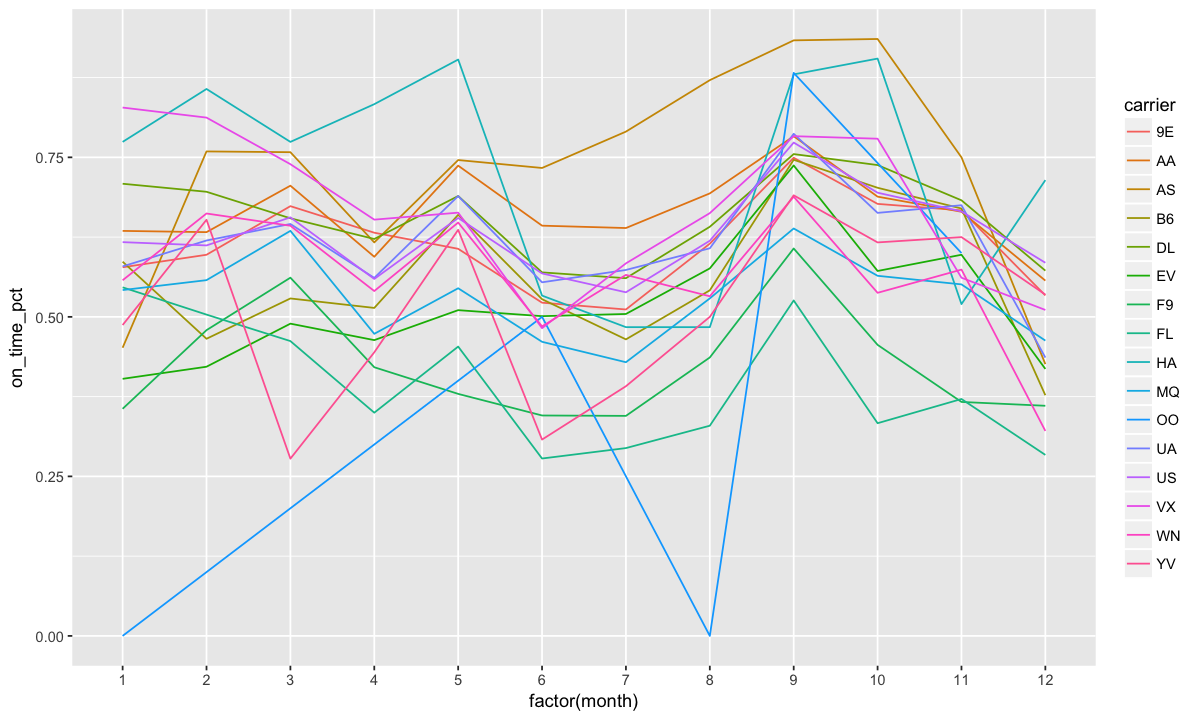

In [50]:
p

Step one will be to figure out how to compute on-time percentage. 

In [37]:
# 

In [38]:
ot = flights %>% mutate(on_time=arr_delay <= 0) %>% 
    select(month, carrier, on_time) %>% print

# A tibble: 336,776 x 3
   month carrier on_time
   <int> <chr>   <lgl>  
 1     1 UA      FALSE  
 2     1 UA      FALSE  
 3     1 AA      FALSE  
 4     1 B6      TRUE   
 5     1 DL      TRUE   
 6     1 UA      FALSE  
 7     1 B6      FALSE  
 8     1 EV      TRUE   
 9     1 B6      TRUE   
10     1 AA      FALSE  
# ... with 336,766 more rows


In [39]:
ot = ot %>% group_by(carrier, month) %>%
            summarize(on_time_pct=mean(on_time, na.rm=T), n=n()) %>% 
    print

# A tibble: 185 x 4
# Groups:   carrier [?]
   carrier month on_time_pct     n
   <chr>   <int>       <dbl> <int>
 1 9E          1       0.578  1573
 2 9E          2       0.597  1459
 3 9E          3       0.674  1627
 4 9E          4       0.632  1511
 5 9E          5       0.607  1462
 6 9E          6       0.522  1437
 7 9E          7       0.512  1494
 8 9E          8       0.615  1456
 9 9E          9       0.749  1540
10 9E         10       0.677  1673
# ... with 175 more rows


Step two is to use this new table to make the plot.

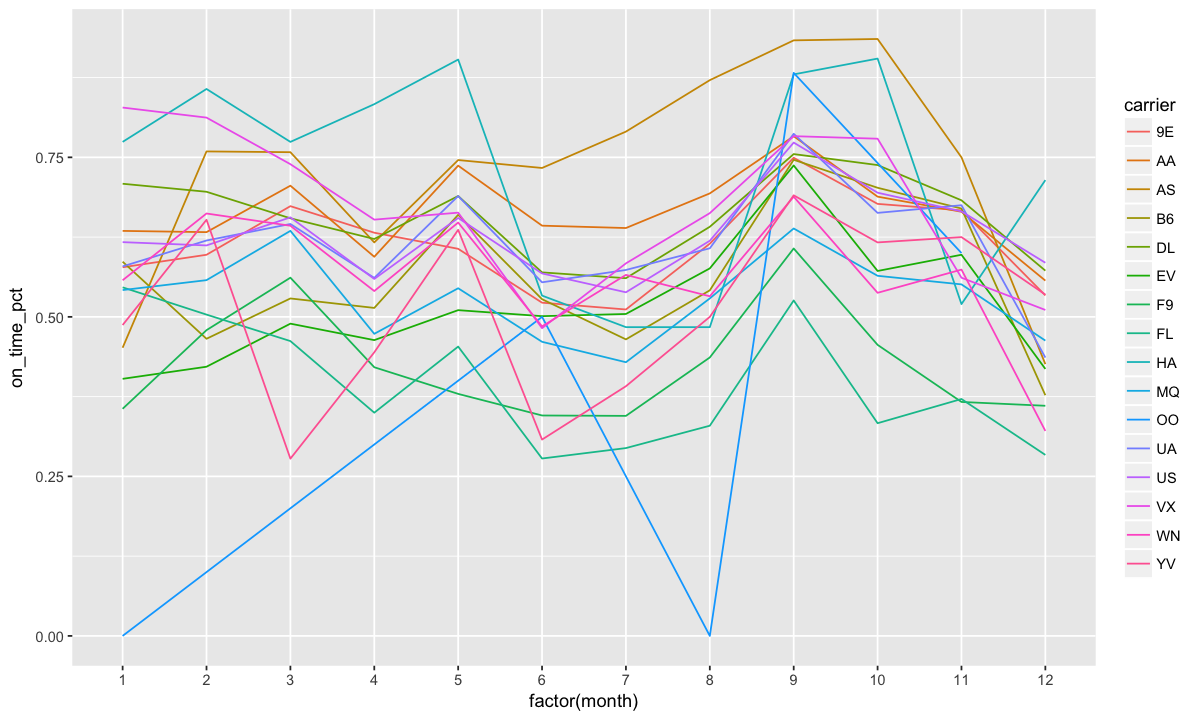

In [40]:
ot %>% ggplot(aes(x=factor(month), y=on_time_pct, 
                  group=carrier, color=carrier)) + 
       geom_line()

This is what we want, but is too busy. Let's filter down to only the carriers that have a pretty high number of observations.

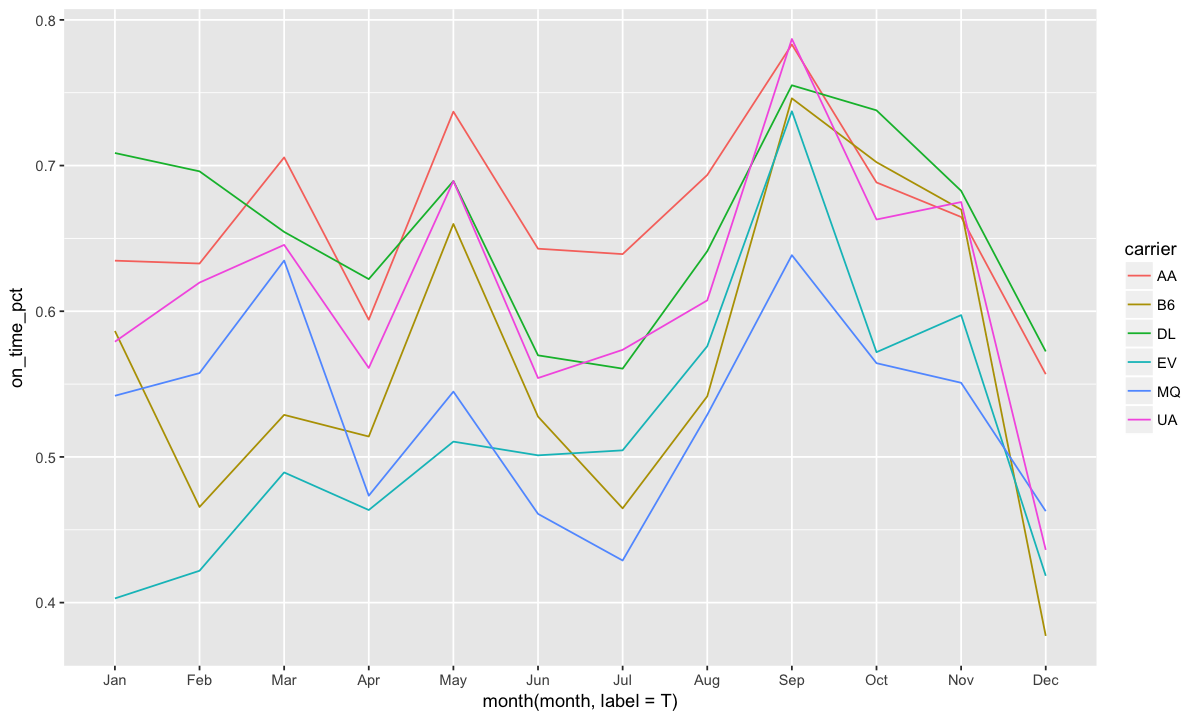

In [41]:
ot %>% filter(n > 2000) %>%  
       ggplot(aes(x=month(month, label=T), y=on_time_pct, group=carrier, color=carrier)) + 
       geom_line()

Finally, let's make the axis labels more readable.

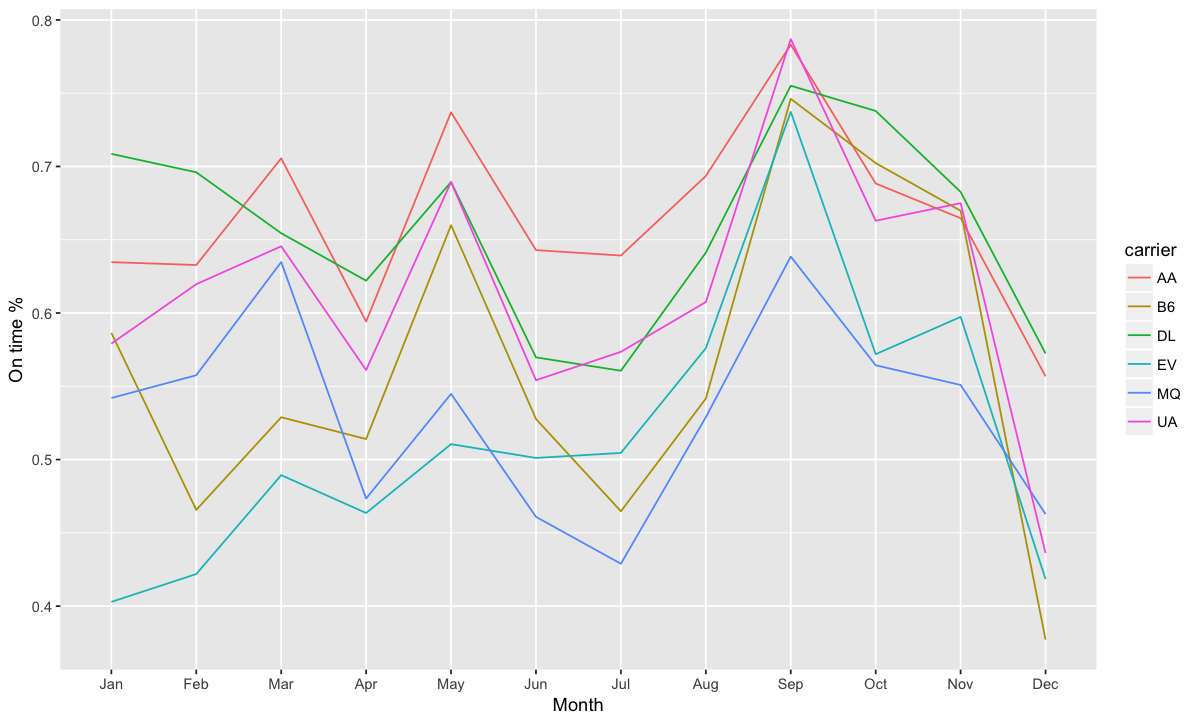

In [42]:
ot %>% filter(n > 2000) %>%  
       ggplot(aes(x=month(month, label=T), y=on_time_pct, group=carrier, color=carrier)) + 
       geom_line() + xlab('Month') + ylab("On time %")

#### Restrict to the top $k$ airlines
In the preceding example we narrowed down to an arbitrarily chosen threshold of `n>2000` in order to make the plot less cluttered. Let's do this in a data-driven manner by looking at what total share of observations are attribut

In [43]:
top_flights = flights %>% group_by(carrier) %>% count %>% arrange(n) %>% ungroup() %>% 
              mutate(cd=cumsum(n)/sum(n)) %>% print

# A tibble: 16 x 3
   carrier     n        cd
   <chr>   <int>     <dbl>
 1 OO         32 0.0000950
 2 HA        342 0.00111  
 3 YV        601 0.00290  
 4 F9        685 0.00493  
 5 AS        714 0.00705  
 6 FL       3260 0.0167   
 7 VX       5162 0.0321   
 8 WN      12275 0.0685   
 9 9E      18460 0.123    
10 US      20536 0.184    
11 MQ      26397 0.263    
12 AA      32729 0.360    
13 DL      48110 0.503    
14 EV      54173 0.664    
15 B6      54635 0.826    
16 UA      58665 1        


Almost 2/3rds of the flights are from the top six carriers, which happen to be the ones we chose in the earlier graph. So we can feel confident in our choice, knowing that there is plenty of support for it in the data.

## Visualizing Distributions
We will briefly go over how to visualize distributions. We already saw examples of this earlier when we lookd at `geom_bar()`, `geom_bin2d()` and `geom_hex()`.


To make things more interesting we are going to look at a different data set than the one in the book. The dataset contains information on [billionaires](https://think.cs.vt.edu/corgis/csv/billionaires/billionaires.html): who they are, where they are from, how & when they made their fortune, etc.

In [52]:
load('bil.RData')

### Exercise:

(Basic)
Who is the youngest billionaire in this dataset?

(Advanced)
Which country has the most billionaires under 30? Which country has the most billionaires over 90?

In [ ]:
# Your code here

## Visualizing discrete distributions
We saw how to visualize the distribution of a discrete random variable: make a bar plot. For example, in the `billionaire` data set, `region` is categorical:

In [57]:
table(bil$region)


               East Asia                   Europe            Latin America 
                     535                      698                      182 
Middle East/North Africa            North America               South Asia 
                     117                      992                       69 
      Sub-Saharan Africa 
                      20 

Say we are interested in the distribution of `region`. We can plot a bar chart to visualize this:

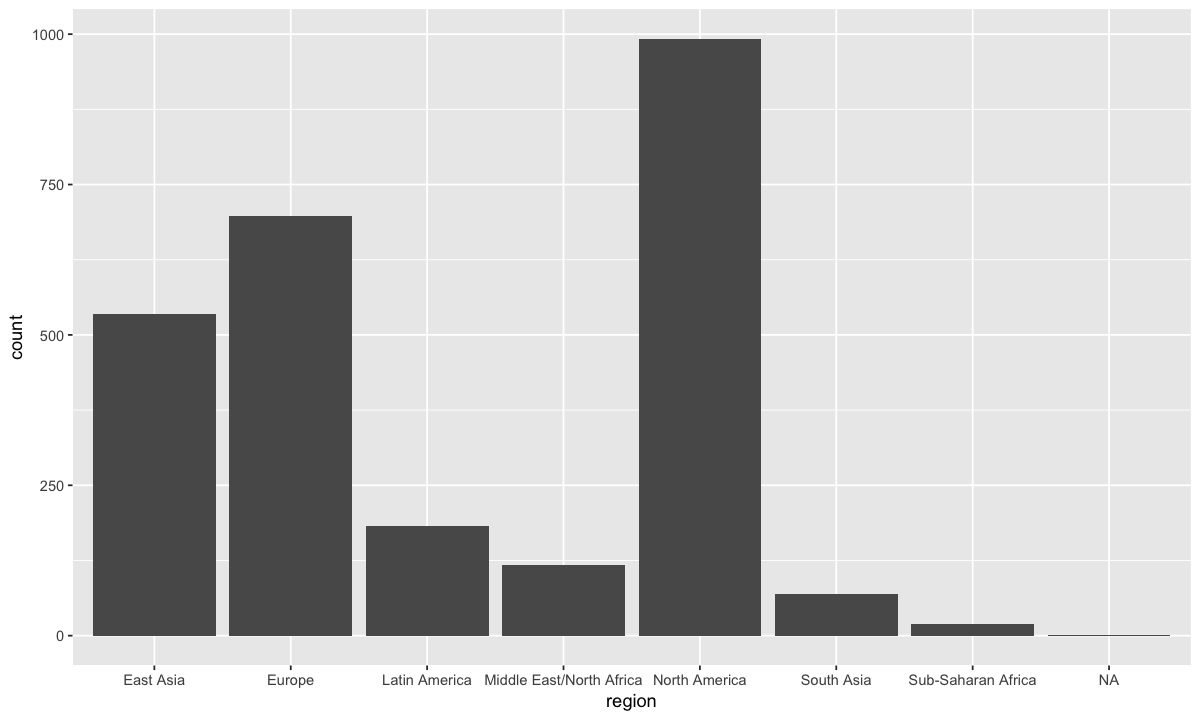

In [58]:
ggplot(data = bil) + geom_bar(mapping = aes(x = region))

## Continuous random variables
We cannot directly use a bar plot to visualize a continuous random variable, because every observation potentially has a different value. Instead we create a **histogram**. The command to do this is **geom_histogram**.

Let's visualize the distribution of wealth among billionaires. 

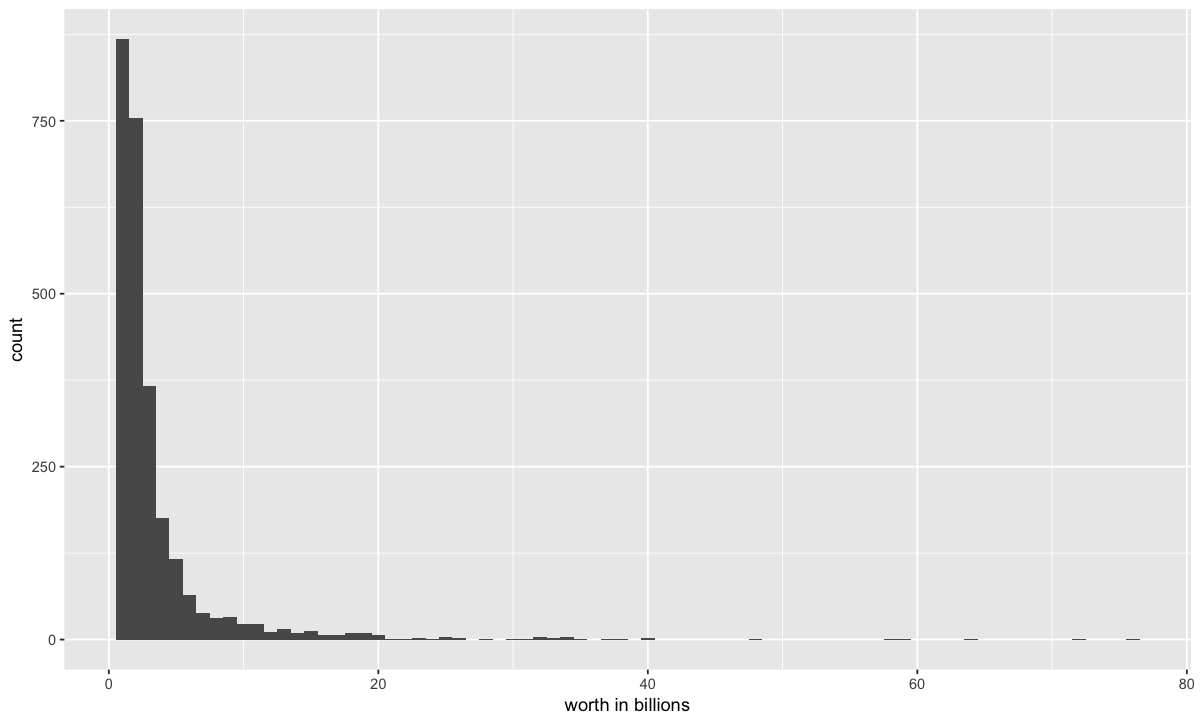

In [76]:
ggplot(data = bil) +
    geom_histogram(mapping = aes(x = `worth in billions`), binwidth = 1)

Most billionaires are worth a paltry \\$1-5b. However, the distribution has a "long tail": there are some billionaires who are worth as much as \\$60-80b. Interestingly, the income distribution among billionaires looks quite a bit like the income distribution in society as a whole. Even the .001% have their 1%.

A histogram is basically a bar plot where the continuous random variable has been *quantized* into one of a finite number of values. To gain intuition for how histograms work we are going to reproduce one by hand. To do this we'll use a function called `cut_width`. This function takes a real-valued vector `v` and a number `k`, and counts how many observations fall into buckets of width `k`. It's easiest to see with an example:

bil_buck <- bil %>% select(`worth in billions`) %>% 
    mutate(bucket=cut_width(`worth in billions`, 1)) %>% print

### Exercise
Make a bar plot of `bucket`. Compare it with the histogram above.

In [ ]:
# Your code here

## Typical and Atypical Values
In EDA, it is a good idea to try and get a sense of what constitutes a "typical" value in your data. Let's look at the disribution of the ages of billionaires:

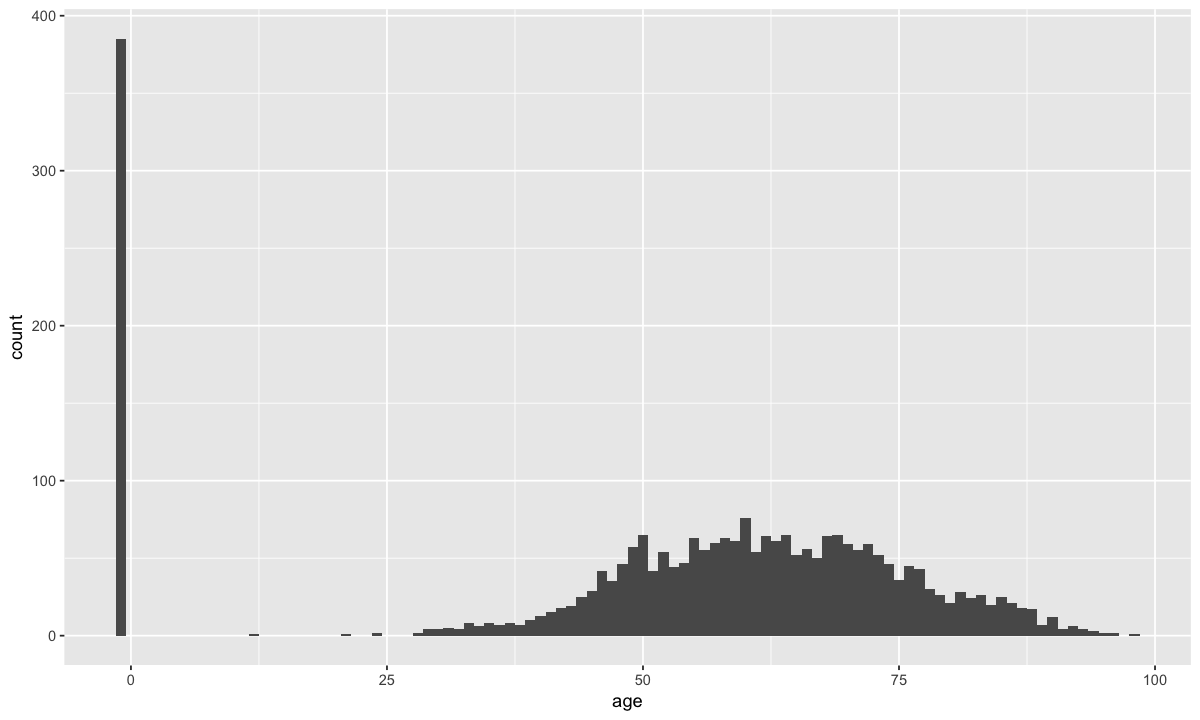

In [59]:
ggplot(data = bil) +
    geom_histogram(mapping = aes(x = age), binwidth = 1)

Typical values of `age` in these data range from about 30 to 90. We see a very unusual spike around zero:

In [60]:
filter(bil, age < 10) %>% arrange(age) %>% print

# A tibble: 385 x 22
     age category  citizenship company.name company.type `country code` founded
   <int> <chr>     <chr>       <chr>        <chr>        <chr>            <int>
 1    -1 Financial Saudi Arab… Rolaco Trad… new          SAU               1968
 2    -1 Financial Hong Kong   Swire        new          HKG               1816
 3    -1 Traded S… Bahrain     YBA Kanoo    new          BHR               1890
 4    -1 New Sect… Japan       Otsuka Hold… new          JPN               1921
 5    -1 Traded S… Japan       Sony         new          JPN               1946
 6    -1 Traded S… France      Chanel       new          FRA               1909
 7    -1 Non-Trad… Mexico      Groupo IUSA  new          MEX               1939
 8    -1 Financial Mexico      Pulsar Inte… new          MEX               1981
 9    -1 Traded S… Netherlands Heineken In… new          NLD               1864
10    -1 <NA>      United Sta… MBNA         subsidiary   USA               1982
# ... with 375 more

These represent missing data where we do not know the person's age. We'll fix this by *recoding* all values of -1 to `NA`:

In [62]:
bil <- mutate(bil, age = ifelse(age == -1, NA, age)) %>% print

# A tibble: 2,614 x 22
     age category  citizenship company.name company.type `country code` founded
   <int> <chr>     <chr>       <chr>        <chr>        <chr>            <int>
 1    NA Financial Saudi Arab… Rolaco Trad… new          SAU               1968
 2    34 Financial United Sta… Fidelity In… new          USA               1946
 3    59 Non-Trad… Brazil      Companhia B… new          BRA               1948
 4    61 New Sect… Germany     Ratiopharm   new          DEU               1881
 5    NA Financial Hong Kong   Swire        new          HKG               1816
 6    NA Traded S… Bahrain     YBA Kanoo    new          BHR               1890
 7    NA New Sect… Japan       Otsuka Hold… new          JPN               1921
 8    NA Traded S… Japan       Sony         new          JPN               1946
 9    66 Financial Japan       Mori Buildi… new          JPN               1959
10    NA Traded S… France      Chanel       new          FRA               1909
# ... with 2,604 

Note that this can also be written more cleanly as 

```bil <- mutate(bil, age = na_if(age, -1)) %>% print```

A good way to get a sense of typical values is by looking at percentiles. The $p$th percentile of a column is the number $x$ for which $p$% of the values are less than or equal to $x$. The best known example is the *median*: half the values are below the median.

In [66]:
(q = quantile(bil$age, probs=c(.01, .5, .99), na.rm=T))

   1%   50%   99% 
32.28 62.00 90.00 

This tells us that 98% of the billionaires are between 32 and 90. Let us redo the visualization with extreme values filtered out.

### Exercise
Reproduce the following plot, showing the age distribution of billionaires between the 25th and 75th percentiles:
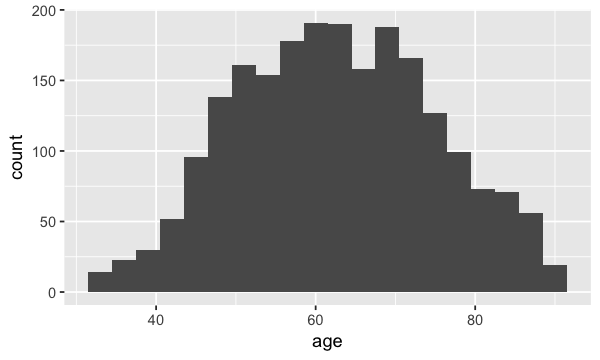

## Diamond pricing
Here is another example where EDA turns up something unexpected. Let's look at the distribution of `diamonds$carat`.

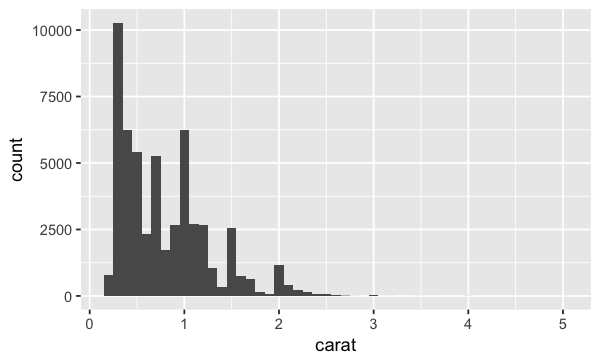

In [68]:
ggplot(data = diamonds) +
    geom_histogram(mapping = aes(x = carat), binwidth = .1)

What's going on near 3? Let us investigate...

In [69]:
filter(diamonds, carat > 3) %>% arrange(carat) %>% print

# A tibble: 32 x 10
   carat cut     color clarity depth table price     x     y     z
   <dbl> <ord>   <ord> <ord>   <dbl> <dbl> <int> <dbl> <dbl> <dbl>
 1  3.01 Premium I     I1       62.7    58  8040  9.1   8.97  5.67
 2  3.01 Premium F     I1       62.2    56  9925  9.24  9.13  5.73
 3  3.01 Fair    H     I1       56.1    62 10761  9.54  9.38  5.31
 4  3.01 Premium G     SI2      59.8    58 14220  9.44  9.37  5.62
 5  3.01 Ideal   J     SI2      61.7    58 16037  9.25  9.2   5.69
 6  3.01 Ideal   J     I1       65.4    60 16538  8.99  8.93  5.86
 7  3.01 Premium I     SI2      60.2    59 18242  9.36  9.31  5.62
 8  3.01 Fair    I     SI2      65.8    56 18242  8.99  8.94  5.9 
 9  3.01 Fair    I     SI2      65.8    56 18242  8.99  8.94  5.9 
10  3.01 Good    I     SI2      63.9    60 18242  9.06  9.01  5.77
# ... with 22 more rows


Okay, now let us zoom into the **carat** range around 1.

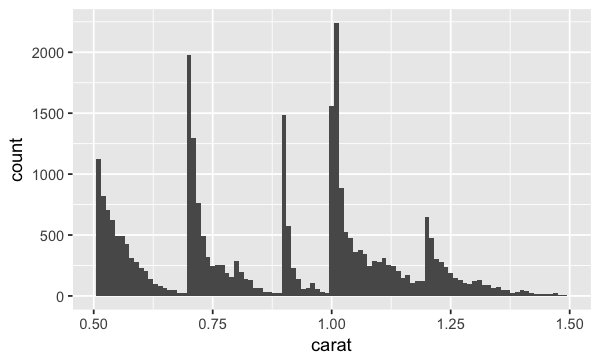

In [70]:
filter(diamonds, carat > 0.5, carat < 1.5) %>% 
    ggplot() + geom_histogram(mapping = aes(x = carat), 
    binwidth = 0.01)

What might explain the strange histogram above? Tendency to round the **carat** values? It seems like certain values are particularly likely to be rounded. Let's refine the plot using the `breaks=` option to investigate further:

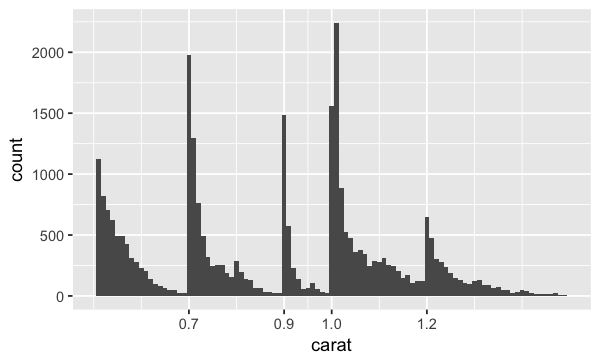

In [71]:
filter(diamonds, carat > 0.5, carat < 1.5) %>% ggplot() + geom_histogram(mapping = aes(x = carat), 
    binwidth = 0.01) + scale_x_continuous(breaks=c(.7,.9,1.,1.2))

Sure enough, there are certain values of carat that people seem to particularly desire.